# Predicción del desempeño de aspirantes a Medical Colleges of Assam
**Curso:** Operaciones de Aprendizaje Automático  
**Integrantes:** Jorge Moya (A00813287), ...  
**Dataset:** CEE_DATA.arff  

Este notebook realiza las siguientes etapas:  
1. Exploración de datos (EDA)  
2. Limpieza y estandarización  
3. Preprocesamiento (Ordinal + One-Hot Encoding)  
4. División de datos en entrenamiento/prueba  
5. Construcción, ajuste y evaluación de modelos de Machine Learning  
6. Guardado del modelo y dataset preprocesado

In [1]:
#ROL SUGERIDO: SOFTWARE ENGINEER - Instalación e importación de librerias

# ==============================
# Instalación de librerías (solo primera vez)
# ==============================

# Usa %pip (más seguro que !pip en Jupyter)
%pip install xgboost catboost imbalanced-learn scipy seaborn matplotlib scikit-learn pandas numpy --quiet

# ==============================
# Importar librerías
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from scipy.io import arff
import os

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.chdir("..")  # Moverse desde /notebooks al directorio raíz del proyecto
print("Directorio actual:", os.getcwd())

os.makedirs("data/processed", exist_ok=True)
os.makedirs("data/models", exist_ok=True)

Directorio actual: C:\Users\Jorge Moya\Documents\Academic\I.T.E.S.M\M.E. Inteligencia Artificial Aplicada\4to Trimestre\Operaciones de aprendizaje automático\Tareas o Trabajos\ml-CEE_DATA-project


# Carga y limpieza de datos
- Cargar el dataset original.
- Limpiar nombres de columnas.
- Revisar tipos de datos, valores nulos y distribución de la variable objetivo.


In [20]:
#ROL SUGERIDO: DATA ENGINEER - Carga de datos ARFF a DataFrame y limpieza básica

# Ruta al archivo dentro de tu Drive
arff_file = 'data/raw/CEE_DATA.arff'

# Cargar ARFF en estructura (data, meta)
data = arff.loadarff(arff_file)
df = pd.DataFrame(data[0])  # convertir a DataFrame pandas

# Los valores categóricos a menudo se cargan como bytes (b'...'); convertirlos a string
# Esto debe formar parte de la limpieza inicial para evitar prefijos b'' en las columnas
for col in df.select_dtypes([object]).columns:
    df[col] = df[col].apply(lambda x: x.decode() if isinstance(x, bytes) else x)

# Mostrar primeras filas para confirmar carga correcta
df.head()

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,Excellent,male,General,NO,ONE,SEBA,AHSEC,ENGLISH,Excellent,Excellent,DOCTOR,OTHERS
1,Excellent,male,OBC,WA,TWO,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,HOUSE_WIFE
2,Excellent,male,OBC,OA,TWO,OTHERS,CBSE,ENGLISH,Excellent,Excellent,BUSINESS,HOUSE_WIFE
3,Excellent,male,General,WA,ONE,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,SCHOOL_TEACHER
4,Excellent,male,General,OA,TWO,SEBA,CBSE,ENGLISH,Excellent,Excellent,COLLEGE_TEACHER,HOUSE_WIFE


In [21]:
#ROL SUGERIDO: DATA SCIENTIST - Análisis de frecuencias de columnas categóricas (EDA inicial)

# Columnas categóricas (puedes ajustarlas según tu dataset)
categorical_cols = ['Gender', 'Caste', 'coaching', 'time', 'Class_ten_education',
                    'twelve_education', 'medium', 'Father_occupation', 'Mother_occupation']

# Crear un diccionario con frecuencias relativas
freq_report = {}

for col in categorical_cols:
    freq_report[col] = df[col].value_counts(normalize=True).sort_values(ascending=False) * 100

# Mostrar resultados
for col, freqs in freq_report.items():
    print(f"\nColumna: {col}")
    print(freqs.round(2))


Columna: Gender
Gender
male      53.3
female    46.7
Name: proportion, dtype: float64

Columna: Caste
Caste
General    49.40
OBC        24.32
ST         16.22
SC         10.06
Name: proportion, dtype: float64

Columna: coaching
coaching
WA    67.42
NO    22.52
OA    10.06
Name: proportion, dtype: float64

Columna: time
time
TWO      55.26
ONE      29.88
THREE    12.91
FOUR      1.65
FIVE      0.15
SEVEN     0.15
Name: proportion, dtype: float64

Columna: Class_ten_education
Class_ten_education
SEBA      59.46
CBSE      37.39
OTHERS     3.15
Name: proportion, dtype: float64

Columna: twelve_education
twelve_education
AHSEC     55.26
CBSE      43.54
OTHERS     1.20
Name: proportion, dtype: float64

Columna: medium
medium
ENGLISH     80.48
OTHERS      11.11
ASSAMESE     8.41
Name: proportion, dtype: float64

Columna: Father_occupation
Father_occupation
OTHERS             41.59
SCHOOL_TEACHER     16.37
BUSINESS           15.47
DOCTOR              8.26
ENGINEER            6.76
COLLEGE_TEAC

Dimensiones del dataset: (666, 12)

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Performance           666 non-null    object
 1   Gender                666 non-null    object
 2   Caste                 666 non-null    object
 3   coaching              666 non-null    object
 4   time                  666 non-null    object
 5   Class_ten_education   666 non-null    object
 6   twelve_education      666 non-null    object
 7   medium                666 non-null    object
 8   Class_ X_Percentage   666 non-null    object
 9   Class_XII_Percentage  666 non-null    object
 10  Father_occupation     666 non-null    object
 11  Mother_occupation     666 non-null    object
dtypes: object(12)
memory usage: 62.6+ KB


None


Número de duplicados detectados: 44

Valores únicos por columna categórica (muestra):

Columna: Performance
['Excellent' 'Vg' 'Good' 'Average']

Columna: Gender
['male' 'female']

Columna: Caste
['General' 'OBC' 'SC' 'ST']

Columna: coaching
['NO' 'WA' 'OA']

Columna: Class_ten_education
['SEBA' 'OTHERS' 'CBSE']

Columna: twelve_education
['AHSEC' 'CBSE' 'OTHERS']

Columna: medium
['ENGLISH' 'OTHERS' 'ASSAMESE']

Columna: Father_occupation
['DOCTOR' 'SCHOOL_TEACHER' 'BUSINESS' 'COLLEGE_TEACHER' 'OTHERS'
 'BANK_OFFICIAL' 'ENGINEER' 'CULTIVATOR']

Columna: Mother_occupation
['OTHERS' 'HOUSE_WIFE' 'SCHOOL_TEACHER' 'DOCTOR' 'COLLEGE_TEACHER'
 'BANK_OFFICIAL' 'BUSINESS' 'CULTIVATOR' 'ENGINEER']

Columna: Class_ X_Percentage
['Excellent' 'Vg' 'Good' 'Average']

Columna: Class_XII_Percentage
['Excellent' 'Vg' 'Good' 'Average']

Columna: time
['ONE' 'TWO' 'THREE' 'FOUR' 'FIVE' 'SEVEN']


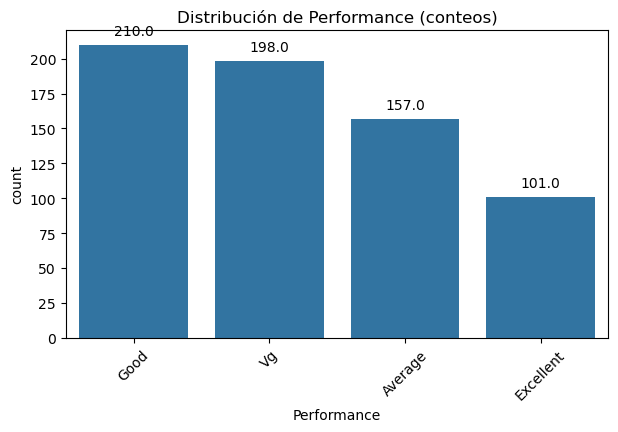

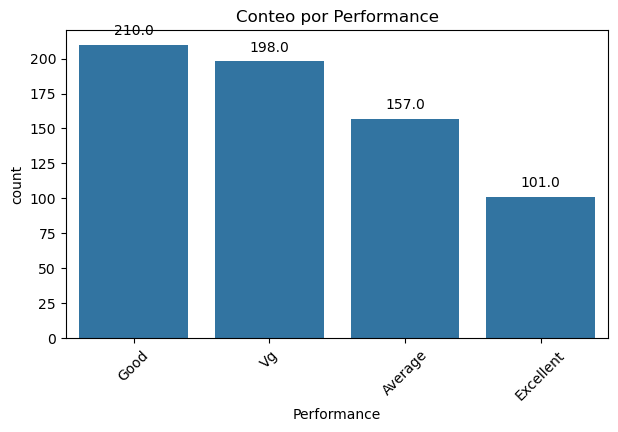

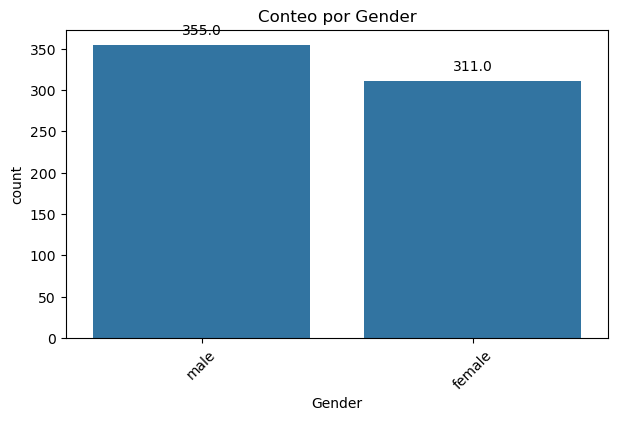

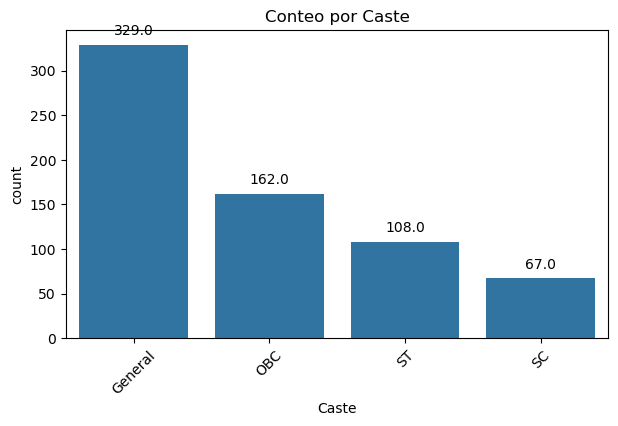

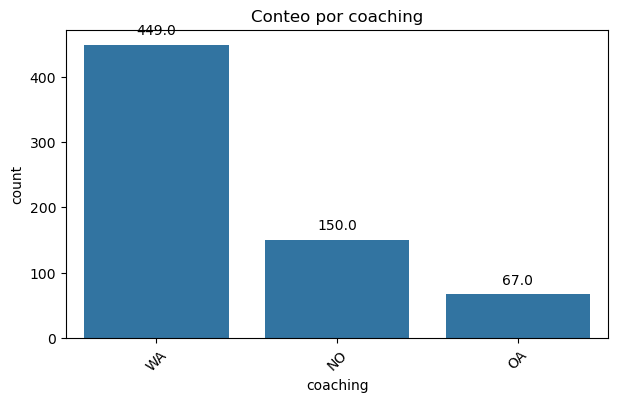

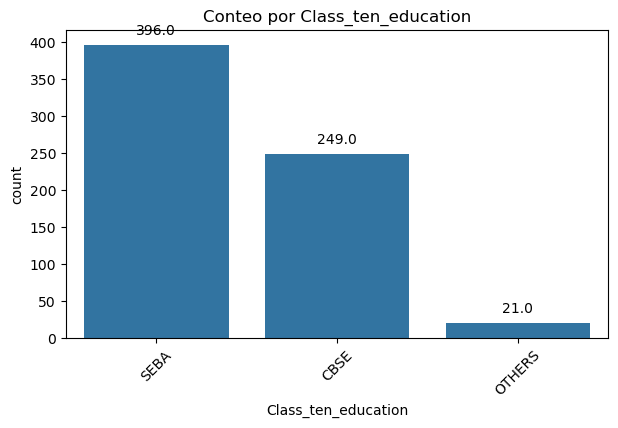

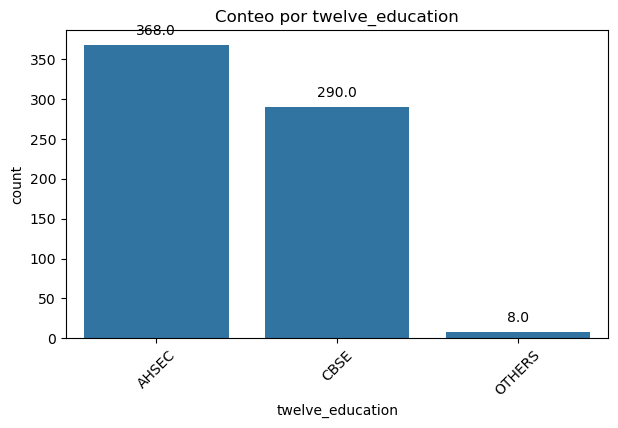

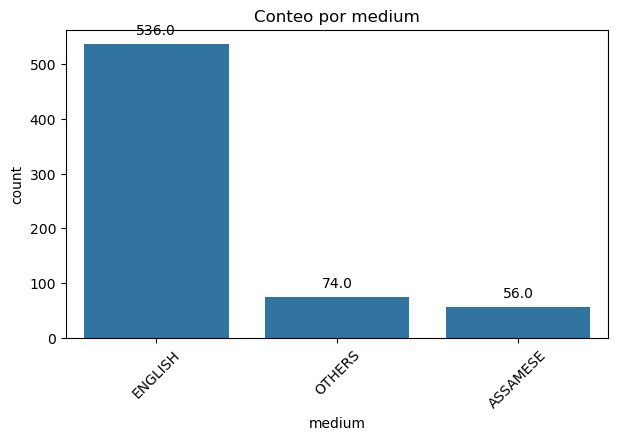

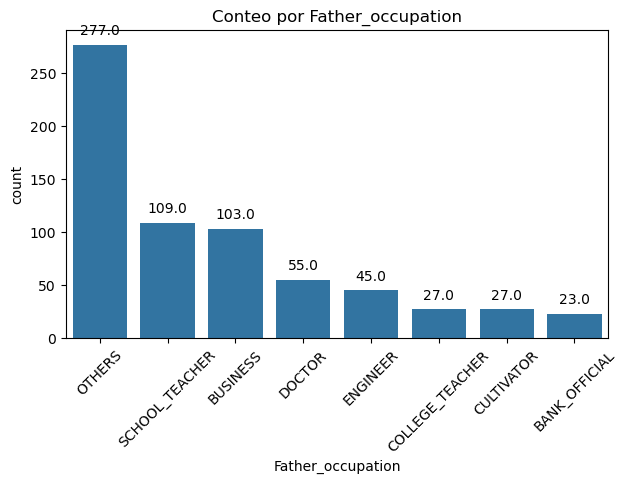

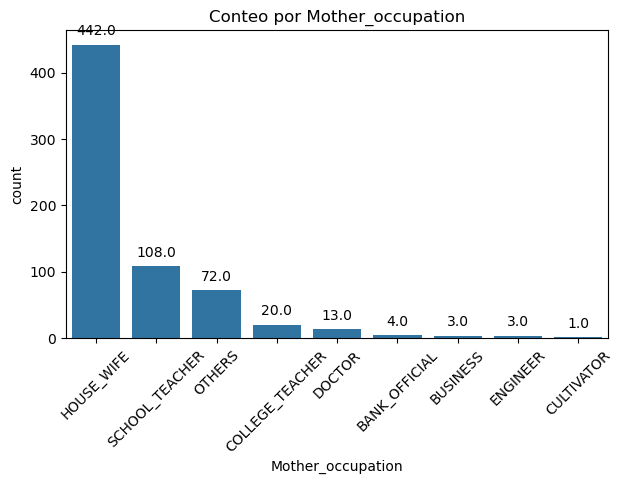

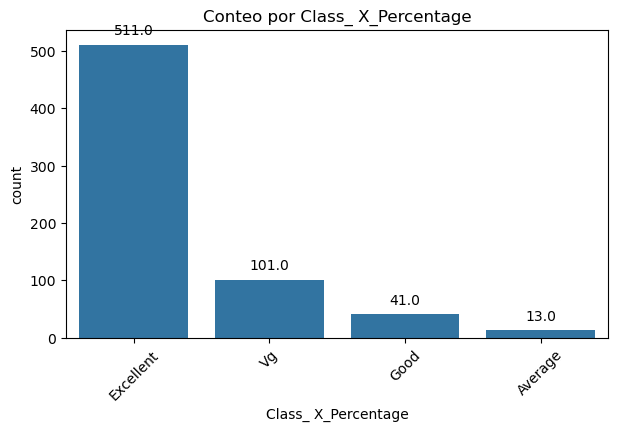

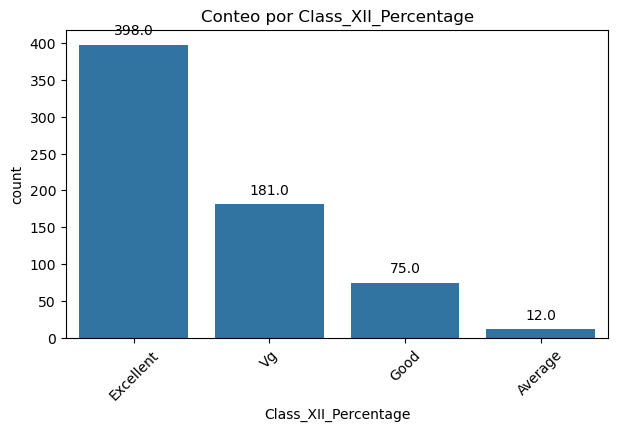

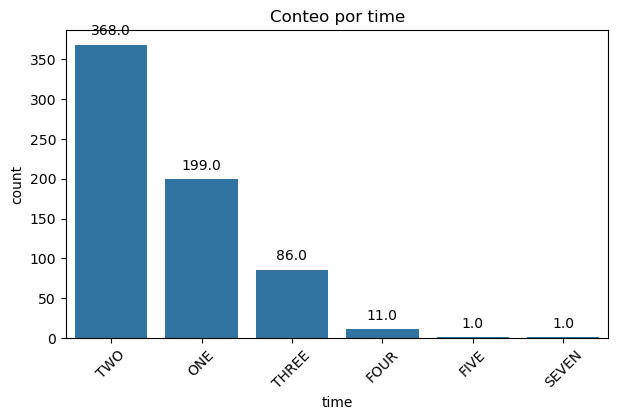

In [22]:
#ROL SUGERIDO: DATA SCIENTIST - EDA más detallado: info, duplicados, distribuciones gráficas

# Columnas de interés según descripción del dataset
ordinal_cols = ['time']  # inicialmente se considera ordinal
nominal_cols = ['Performance', 'Gender', 'Caste', 'coaching',
                'Class_ten_education', 'twelve_education', 'medium',
                'Father_occupation', 'Mother_occupation',
                'Class_ X_Percentage', 'Class_XII_Percentage']

# 1) Dimensiones y tipos
print("Dimensiones del dataset:", df.shape)
print("\nInformación general:")
display(df.info())  # display para notebooks

# 2) Duplicados
n_duplicados = df.duplicated().sum()
print(f"\nNúmero de duplicados detectados: {n_duplicados}")

# 3) Valores únicos por columna categórica (útil para detectar errores ortográficos / variantes)
print("\nValores únicos por columna categórica (muestra):")
for col in nominal_cols + ordinal_cols:
    print(f"\nColumna: {col}")
    print(df[col].unique())   # revisar manualmente y detectar inconsistencias

# 4) Distribución de la variable objetivo (conteos) con número encima
plt.figure(figsize=(7,4))
ax = sns.countplot(data=df, x='Performance', order=df['Performance'].value_counts().index)
plt.title('Distribución de Performance (conteos)')
plt.xticks(rotation=45)

# Añadir número encima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x() + p.get_width()/2, height),
                xytext=(0,5), textcoords='offset points', ha='center', va='bottom')

plt.show()

# 5) Conteos ordenados para todas las columnas categóricas (con número encima)
for col in nominal_cols + ordinal_cols:
    plt.figure(figsize=(7,4))
    order = df[col].value_counts().index
    ax = sns.countplot(data=df, x=col, order=order)
    plt.title(f'Conteo por {col}')
    plt.xticks(rotation=45)

    # Añadir número encima de cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', xy=(p.get_x() + p.get_width()/2, height),
                    xytext=(0,5), textcoords='offset points', ha='center', va='bottom')

    plt.show()


## Limpieza

Acciones que se ejecutan en esta etapa:
- Eliminar registros duplicados.
- Identificar y marcar valores nulos/invalidos (se muestran luego para decidir imputación).


In [23]:
#ROL SUGERIDO: DATA ENGINEER - Limpieza: eliminación de duplicados, revisión de nulos

# 1) Eliminar duplicados detectados en EDA
df = df.drop_duplicates()
print("Dimensiones tras eliminar duplicados:", df.shape)

# 2) Revisar valores nulos generados por la conversión (si hubieran entradas inesperadas)
print("\nValores nulos por columna después de limpieza inicial:")
print(df.isnull().sum())


Dimensiones tras eliminar duplicados: (622, 12)

Valores nulos por columna después de limpieza inicial:
Performance             0
Gender                  0
Caste                   0
coaching                0
time                    0
Class_ten_education     0
twelve_education        0
medium                  0
Class_ X_Percentage     0
Class_XII_Percentage    0
Father_occupation       0
Mother_occupation       0
dtype: int64


In [24]:
processed_path = "data/processed/CEE_DATA_clean.csv"
df.to_csv(processed_path, index=False)
print(f"Archivo preprocesado guardado en: {processed_path}")

Archivo preprocesado guardado en: data/processed/CEE_DATA_clean.csv


# Agrupación de Performance
- Combinar 'Average' y 'Good' en una categoría.
- Codificar la variable objetivo para modelado.

In [25]:
#ROL SUGERIDO: ML ENGINEER - Agrupación de variable objetivo y codificación (en preparación para el modelado)

# Ruta al archivo procesado (desde raíz del repo)
processed_path = os.path.join("data", "processed", "CEE_DATA_clean.csv")

# Cargar dataset limpio generado por el Data Engineer
df = pd.read_csv(processed_path)

df['Performance_grouped'] = df['Performance'].replace({
    'Average': 'Average/Good',
    'Good': 'Average/Good',
    'Vg': 'Vg',
    'Excellent': 'Excellent'
})

y_grouped = LabelEncoder().fit_transform(df['Performance_grouped'])

# Columnas categóricas


In [26]:
#ROL SUGERIDO: ML ENGINEER - Definición de columnas categóricas

categorical_cols = [
    'Gender', 'Caste', 'coaching', 'time',
    'Class_ten_education', 'twelve_education', 'medium',
    'Father_occupation', 'Mother_occupation'
]

# Combinar categorías raras
- Categorías con frecuencia < 20% se reemplazan por 'OTHERS'.


In [27]:
#ROL SUGERIDO: ML ENGINEER - Combinar categorías raras (preprocesamiento de features)

def combine_rare(df, col, threshold=0.2):
    counts = df[col].value_counts(normalize=True)
    rare = counts[counts < threshold].index
    df[col] = df[col].replace(rare, 'OTHERS')

for col in categorical_cols:
    combine_rare(df, col)

# Feature combinada Academic_Score
- Convertir notas ordinales a numéricas.
- Promedio entre Class_X y Class_XII.

In [28]:
#ROL SUGERIDO: ML ENGINEER - Codificación ordinal y cálculo de Academic_Score

ordinal_cols = ["Class_ X_Percentage", "Class_XII_Percentage"]
ord_map = ["Poor", "Average", "Good", "Vg", "Excellent"]
ord_enc = OrdinalEncoder(categories=[ord_map, ord_map])
df[['Class_X_num', 'Class_XII_num']] = ord_enc.fit_transform(df[ordinal_cols])
df['Academic_Score'] = df[['Class_X_num', 'Class_XII_num']].mean(axis=1)

# Frequency encoding

In [29]:
#ROL SUGERIDO: ML ENGINEER - Frecuencias de categorías como features

for col in categorical_cols:
    freq = df[col].value_counts(normalize=True)
    df[col+'_freq'] = df[col].map(freq)


# Construcción de X

In [30]:
#ROL SUGERIDO: ML ENGINEER - Selección de features X

X = df[[c+'_freq' for c in categorical_cols] + ['Academic_Score']]


# Balanceo de clases con SMOTE


In [31]:
#ROL SUGERIDO: ML ENGINEER - Balanceo de clases con SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y_grouped)


In [32]:
#ROL SUGERIDO: DATA ENGINEER - Exportar dataset preprocesado para ML Engineer

import os

# Crear carpeta de salida si no existe
os.makedirs("data/processed", exist_ok=True)

# Definir ruta final
preprocessed_file = os.path.join("data", "processed", "CEE_DATA_preprocessed.csv")

# Combinar features y target en un solo DataFrame
df_preprocessed = pd.concat(
    [pd.DataFrame(X_res, columns=X.columns).reset_index(drop=True),
     pd.Series(y_res, name='Performance_grouped')],
    axis=1
)

# Guardar el dataset
df_preprocessed.to_csv(preprocessed_file, index=False)

print(f"Dataset preprocesado guardado en: {preprocessed_file}")
print(f"Shape final: {df_preprocessed.shape}")


✅ Dataset preprocesado guardado en: data\processed\CEE_DATA_preprocessed.csv
Shape final: (1038, 11)


In [33]:
df_preprocessed_for_viz = pd.concat([X, df['Performance_grouped']], axis=1)
df_preprocessed_for_viz.to_csv('data/processed/CEE_DATA_for_viz.csv', index=False)


# EDA y visualizaciones


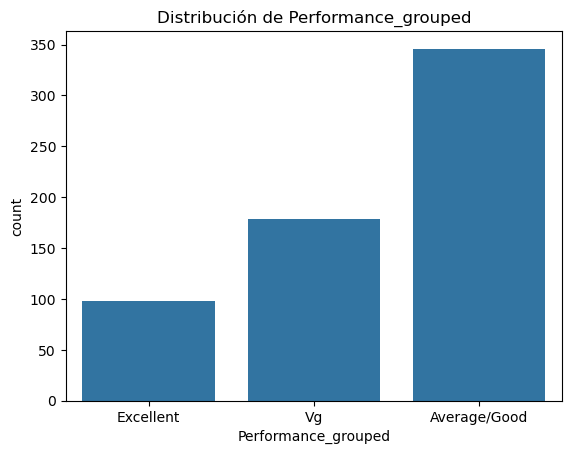

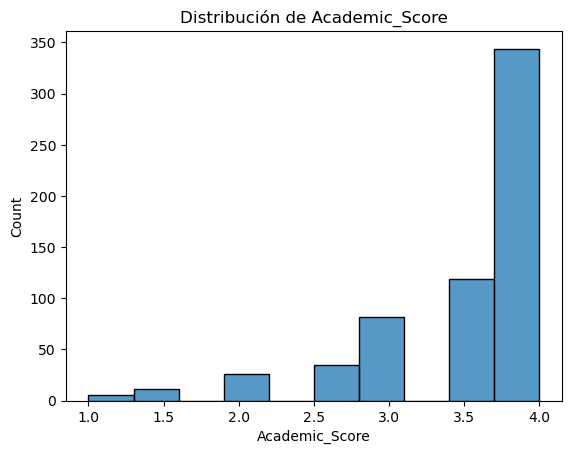

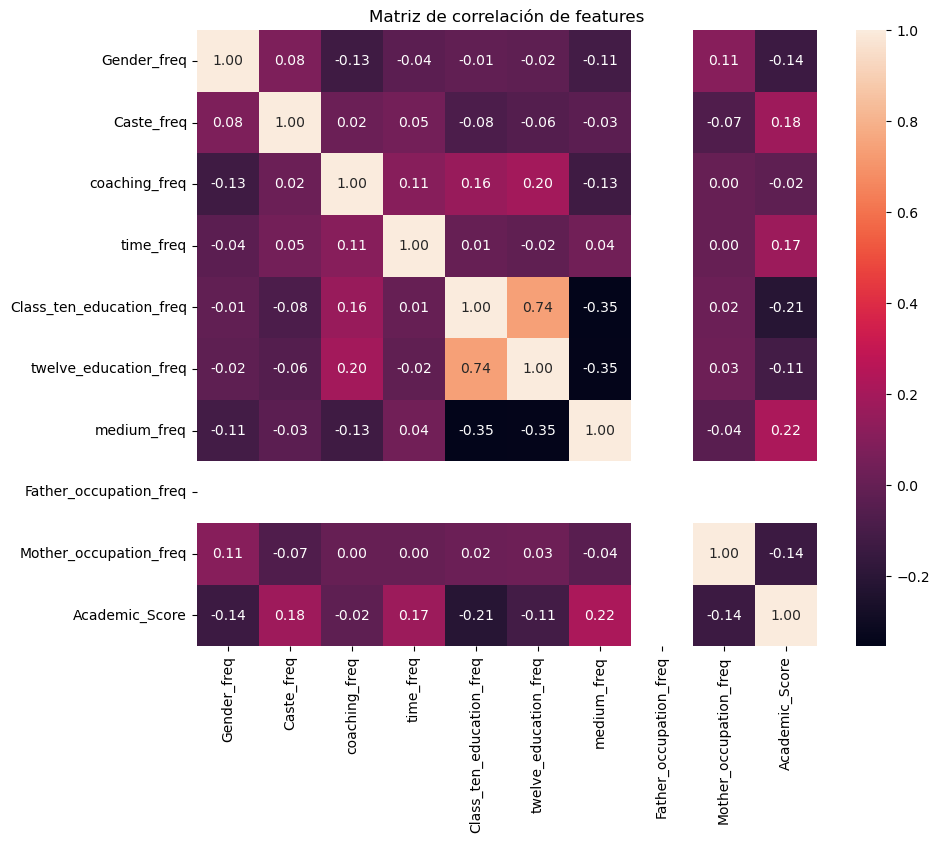

In [34]:
#ROL SUGERIDO: DATA SCIENTIST - Visualizaciones finales: distribuciones y correlaciones

# Ruta al archivo procesado (desde raíz del repo)
processed_path = os.path.join("data", "processed", "CEE_DATA_for_viz.csv")

# Cargar dataset limpio generado por el Data Engineer
df = pd.read_csv(processed_path)
X = df.drop(columns=["Performance_grouped"])

sns.countplot(x='Performance_grouped', data=df)
plt.title('Distribución de Performance_grouped')
plt.show()

sns.histplot(df['Academic_Score'], bins=10)
plt.title('Distribución de Academic_Score')
plt.show()

corr = X.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Matriz de correlación de features')
plt.show()


# Modelos y GridSearchCV


In [35]:
#ROL SUGERIDO: ML ENGINEER - Definición de modelos y búsqueda de hiperparámetros

# Ruta al dataset preprocesado (desde la raíz del repo)
preprocessed_file = 'data/processed/CEE_DATA_preprocessed.csv'
df = pd.read_csv(preprocessed_file)

# Separar features y target
X_res = df.drop(columns=['Performance_grouped'])
y_res = df['Performance_grouped']

models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [300, 500],
            'max_depth': [5, 10, None],
            'min_samples_leaf': [1, 3, 5],
            'max_features': ['sqrt', 'log2']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        'params': {
            'n_estimators': [300, 500],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.05, 0.08, 0.1],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.7, 0.8]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs', 'saga']
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(iterations=800, verbose=0, random_seed=42),
        'params': {
            'depth': [4, 6, 8],
            'learning_rate': [0.03, 0.05, 0.08],
            'l2_leaf_reg': [1, 3, 5]
        }
    }
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='macro')
best_models = {}

for name, m in models.items():
    print(f"\nBuscando hiperparámetros para {name}...")
    gs = GridSearchCV(m['model'], m['params'], cv=cv, scoring=f1_scorer, n_jobs=-1)
    gs.fit(X_res, y_res)
    print(f"Mejor F1: {gs.best_score_:.3f}")
    print("Mejores parámetros:", gs.best_params_)
    best_models[name] = gs.best_estimator_



Buscando hiperparámetros para RandomForest...
Mejor F1: 0.687
Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}

Buscando hiperparámetros para XGBoost...


C:\Users\Jorge Moya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:41:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejor F1: 0.691
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

Buscando hiperparámetros para LogisticRegression...


C:\Users\Jorge Moya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejor F1: 0.556
Mejores parámetros: {'C': 10, 'solver': 'saga'}

Buscando hiperparámetros para CatBoost...
Mejor F1: 0.696
Mejores parámetros: {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}


# Evaluación de modelos


In [ ]:
#ROL SUGERIDO: ML ENGINEER - Evaluación de modelos y matrices de confución

for name, model in best_models.items():
    print(f"\nResultados finales {name}")
    y_pred = model.predict(X_res)
    print(classification_report(y_res, y_pred))
    cm = confusion_matrix(y_res, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Matriz de confusión {name}')
    plt.show()
